<a href="https://colab.research.google.com/github/Ok3ks/Paraphrase-detection/blob/main/Copy_of_paraphrase_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
#Paraphrase detection with a classifier using BERT representation
#THis notebook is based on the Microsoft Research paraphrase corpus where a classifier is trained to detect paraphrases

In [11]:
%pip install transformers
%pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import os 
import pandas as pd
import seaborn as sns
import torch.multiprocessing as torch_mp
import torch
from transformers import RobertaTokenizerFast, RobertaModel, BertTokenizer
from transformers import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.pyplot as plt
import operator
import spacy
#import optuna

In [13]:
!python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 17 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [14]:
nlp = spacy.load("en_core_web_lg")

model = RobertaModel.from_pretrained("roberta-base")
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def make_segment_ids(list_of_tokens):
    #this function assumes that up to and including the first '[SEP]' is the first segment, anything afterwards is the second segment
    current_id=0
    segment_ids=[]
    for token in list_of_tokens:
        segment_ids.append(current_id)
        if token == '[SEP]':
            current_id +=1
    return segment_ids

def tokenize(text):
    text = 'CLS' + text + 'SEP'
    tokens = tokenizer.tokenize(text)
    ids = tokenizer.convert_tokens_to_ids(tokens)
    seg = make_segment_ids(tokens)

    return ids, seg

def load_tsv(tsv_text):
    content = dict()
   
    temp1 = []; temp2 = []; temp3 = []; temp4 = []; temp5 = []
    with open(tsv_text, 'r') as tr:
        for line in tr:
            line = line.split('\t')
            temp1.append(line[0])
            temp2.append(line[1])
            temp3.append(line[2])
            temp4.append(line[3])
            temp5.append(line[4])

    content["Quality"] = temp1[1:]; content["#1 ID"] = temp2[1:]; content["#2 ID"] = temp3[1:]
    content["#1 String"] = temp4[1:]; content["#2 String"] = temp5[1:]

    return content

def plot_confusion_matrix(y_preds, y_true, labels):
    """Plotting confusion matrix given predicted y(y_pred), true y(y_true) and labels"""
    cm = confusion_matrix(y_true, y_preds, labels, normalize= True)
    fig,ax = plt.subplots(len(labels), len(labels))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= labels)
    disp.plot(cmap= "Blues", values_format =".2f", ax = ax, colorbar = False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [16]:
#if torch.cuda.is_available() else "cpu")

def out_hidden_states(text,model, flag = "tensor"):

    """Switches between Arrays and Tensors"""
    device = torch.device("cuda")
    input = tokenizer(text, return_tensors ="pt",padding=True, truncation=True)
    ins = {k:v.to(device) for k,v in input.items()}
    model = model.to(device)

    with torch.no_grad():
        out = model(**ins)[-2]

        if flag == "array":
            out = out[:,0].cpu().numpy()[:,:]

        elif flag == "tensor": 
            out = out[:, 0]

        else :
            print("select 'tensor' or 'array' ")

    return out
def accuracy(y_true, y_pred):
    corr = 0
    if len(y_true) == len(y_pred):
        for a,b in zip(y_true, y_pred):
            if a == b:
                corr += 1
            else:
                pass
        print("The Accuracy of this prediction is {}".format(corr/len(y_true)))
    else:
        print("y_true is not the same as y_pred")
        pass
    return corr/len(y_true)

def accuracy_tensor(probs: torch.FloatTensor, targets: torch.LongTensor) -> float:
    """
    Args:
        probs: A float32 tensor of shape ``(batch_size, class_count)`` where each value 
            at index ``i`` in a row represents the score of class ``i``.
        targets: A long tensor of shape ``(batch_size,)`` containing the batch examples'
            labels.
    """
    predicted = probs.argmax(dim=1)
    corrects = (predicted == targets)
    accuracy = corrects.sum().float() / float( targets.size(0) )
    return accuracy


# Accessing files

In [17]:
MRPC = "Mrpc"

os.listdir(MRPC)

train = MRPC + '/msr_paraphrase_train.txt'
dev = MRPC + '/msr_paraphrase_dev.tsv'
test = MRPC + '/msr_paraphrase_test.txt'
label2id = {1: "paraphrase", 0: "not paraphrase"}

In [18]:
raw_train = pd.DataFrame(load_tsv(train))
raw_dev = pd.DataFrame(load_tsv(dev))
raw_test = pd.DataFrame(load_tsv(test))

columns = raw_train.columns
print(columns)

Index(['Quality', '#1 ID', '#2 ID', '#1 String', '#2 String'], dtype='object')


- Checking distribution of labels

(array([1147.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         578.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

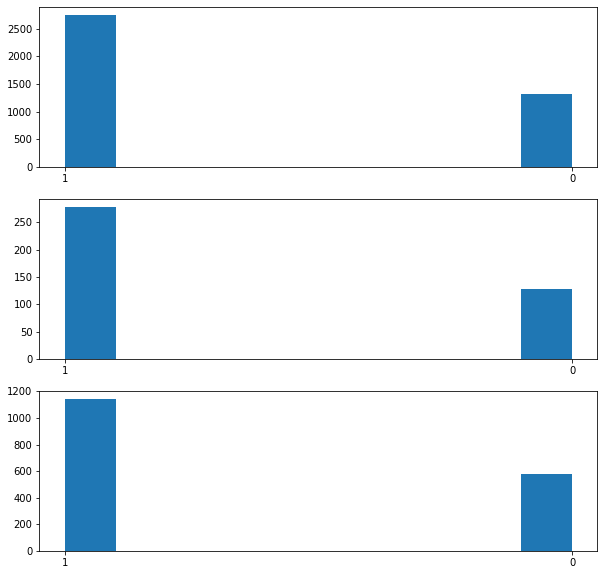

In [19]:
fig,ax = plt.subplots(3, figsize = (10,10))

ax[0].hist(raw_train.Quality)
ax[1].hist(raw_dev.Quality)
ax[2].hist(raw_test.Quality)

# Precomputing roberta embeddings for dataset


In [ ]:
raw_train_1 = out_hidden_states(list(raw_train['#1 String']), model)
torch.save(raw_train_1, "raw_ train_1_string.pt")

raw_train_2 = out_hidden_states(list(raw_train['#2 String']), model)
torch.save(raw_train_2, "raw_train_2_string.pt")

raw_dev_1 = out_hidden_states(list(raw_dev['#1 String']), model)
torch.save(raw_dev_1, "raw_dev_1_string.pt")

raw_dev_2 = out_hidden_states(list(raw_dev['#2 String']), model)
torch.save(raw_dev_2, "raw_dev_2_string.pt")

raw_test_1 = out_hidden_states(list(raw_test['#1 String']), model)
torch.save(raw_test_1, "raw_test_1_string.pt")

raw_test_2 = out_hidden_states(list(raw_test['#2 String']), model)
torch.save(raw_test_2, "raw_test_2_string.pt")

In [ ]:
raw_test_1.size(0)
raw_test['sim'] = 0
for i in range(raw_test_1.size(0)):
  assert raw_test_1.size(0) == raw_test_2.size(0)
  temp = torch.cosine_similarity(raw_test_1[i, :], raw_test_2[i, :])
  raw_test.iloc([i,-1]) = temp

In [ ]:
#Obtaining token ids using BERT Tokenizer for train,dev and test split
 
train_1_id, train_1_seg_id = zip(*raw_train["#1 String"].map(tokenize)) #unpacks 
train_2_id, train_2_seg_id= zip(*raw_train["#2 String"].map(tokenize)) 

dev_1_id, dev_1_seg_id = zip(*raw_dev["#1 String"].map(tokenize)) 
dev_2_id, dev_2_seg_id = zip(*raw_dev["#2 String"].map(tokenize)) 

test_1_id, test_1_seg_id = zip(*raw_test["#1 String"].map(tokenize))
test_2_id, test_2_seg_id  = zip(*raw_test["#2 String"].map(tokenize))

#Obtaining labels to be used in classification head
train_labels = raw_train["Quality"]; dev_labels = raw_dev["Quality"]; test_labels = raw_test["Quality"]

In [ ]:
#Checking function per input
out_hidden_states(raw_train['#1 String'][0]).max()

# Spacy Similarity

- Using Spacy to compute similarity

In [ ]:
tr_1_str = nlp(raw_train['#1 String'][0])
tr_2_str = nlp(raw_train['#2 String'][0])

tr_1_str.similarity(tr_2_str) == tr_2_str.similarity(tr_1_str)

True

In [35]:
spacy_sim = []

for i in range(len(raw_train['#1 String'])):
  spacy_sim.append(nlp(raw_train['#1 String'][i]).similarity(nlp(raw_train['#2 String'][i])))
  print(spacy_sim[-1])

raw_train['spacy_sim'] = spacy_sim
raw_train

0.9491894007046969
0.9351740471716652
0.9505238272159169
0.9424943746237088
0.8882134989950624
0.9695409310231559
0.8051869871354359
0.9473867924758963
0.8908355729212644
0.8693960529239011
0.9523452932365778
0.9489671523028972
0.7984337066644469
0.949162377484594
0.9455790057021183
0.9321398283929649
0.8383952218717534
0.9218069017169779
0.9054561884052099
0.9852351520022585
0.9762788669638123
0.9775019730261625
0.9788137718155545
0.8887154119877904
0.9133626389998776
0.931684011057979
0.9429714630358179
0.9386440470659072
0.9279992830107948
0.822649182344542
0.8668344671590515
0.9032042648660976
0.9147293597532312
0.9356173217111515
0.9092238180666969
0.9098283619899713
0.7979327389950742
0.9567104967800636
0.7455227780619419
0.8607730992154862
0.9677481760104353
0.8705555791079655
0.9664594713844208
0.9603807628699691
0.8438670986266706
0.9730523187713991
0.9019682307070089
0.9289042112730852
0.867623528443527
0.9709604367359983
0.8993917175398474
0.8929293379276813
0.98175127060594

,Quality,#1 ID,#2 ID,#1 String,#2 String,is_alpha_1,is_alpha_2,is_currency_1,is_currency_2,like_num_1,like_num_2,is_punct_1,is_punct_2,pos_1,pos_2,is_oov_1,is_oov_2,is_sent_start_1,is_sent_start_2,spacy_sim
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",14,16,0,0,0,0,5,3,"[PROPN, VERB, PRON, NOUN, PUNCT, PRON, PRON, V...","[VERB, ADP, PRON, ADP, ADV, PUNCT, DET, NOUN, ...",1,1,1,1,0.949189
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,12,12,2,4,6,6,1,0,"[PROPN, VERB, PROPN, PART, ADP, VERB, DET, NOU...","[PROPN, VERB, PROPN, PART, ADP, NUM, ADP, SYM,...",0,0,1,1,0.935174
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",17,17,0,0,2,2,3,2,"[PRON, AUX, VERB, DET, NOUN, ADP, DET, NOUN, A...","[ADP, PROPN, NUM, PUNCT, DET, NOUN, PART, NOUN...",0,0,1,1,0.950524
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",12,13,2,2,8,6,5,4,"[ADV, NUM, PROPN, PUNCT, NOUN, NOUN, AUX, ADV,...","[NOUN, NOUN, VERB, NUM, NOUN, PUNCT, CCONJ, NU...",0,1,1,1,0.942494
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,16,15,4,4,6,6,3,2,"[DET, NOUN, VERB, SYM, NUM, PUNCT, CCONJ, ADV,...","[PROPN, CCONJ, PROPN, PROPN, NOUN, VERB, SYM, ...",1,1,1,1,0.888213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4071,1,1620264,1620507,""" At this point , Mr. Brando announced : ' Som...","Brando said that "" somebody ought to put a bul...",14,16,0,0,0,0,6,4,"[PUNCT, ADP, DET, NOUN, PUNCT, PROPN, PROPN, V...","[PROPN, VERB, SCONJ, PUNCT, PRON, AUX, PART, V...",0,1,1,1,0.898301
4072,0,1848001,1848224,"Martin , 58 , will be freed today after servin...",Martin served two thirds of a five-year senten...,17,18,0,0,6,4,3,2,"[PROPN, PUNCT, NUM, PUNCT, AUX, AUX, VERB, NOU...","[PROPN, VERB, NUM, NOUN, ADP, DET, NUM, PUNCT,...",0,1,1,1,0.919511
4073,1,747160,747144,""" We have concluded that the outlook for price...","In a statement , the ECB said the outlook for ...",26,27,0,0,0,0,4,3,"[PUNCT, PRON, AUX, VERB, SCONJ, DET, NOUN, ADP...","[ADP, DET, NOUN, PUNCT, DET, PROPN, VERB, DET,...",0,0,1,1,0.923923
4074,1,2539933,2539850,The notification was first reported Friday by ...,MSNBC.com first reported the CIA request on Fr...,8,7,0,0,2,2,1,1,"[DET, NOUN, AUX, ADV, VERB, PROPN, ADP, PROPN,...","[PROPN, ADV, VERB, DET, PROPN, NOUN, ADP, PROP...",0,0,1,1,0.722712


# *Pairing* Spacy with custom Bertpiece tokenizer and Sentecepiece tokenizer

In [ ]:
from tokenizers import BertWordPieceTokenizer
from spacy.tokens import Doc
import spacy

class BertTokenizer:
    def __init__(self, vocab, vocab_file, lowercase=True):
        self.vocab = vocab
        self._tokenizer = BertWordPieceTokenizer(vocab_file, lowercase=lowercase)

    def __call__(self, text):
        tokens = self._tokenizer.encode(text)
        words = []
        spaces = []
        for i, (text, (start, end)) in enumerate(zip(tokens.tokens, tokens.offsets)):
            words.append(text)
            if i < len(tokens.tokens) - 1:
                # If next start != current end we assume a space in between
                next_start, next_end = tokens.offsets[i + 1]
                spaces.append(next_start > end)
            else:
                spaces.append(True)
        return Doc(self.vocab, words=words, spaces=spaces)

In [ ]:
nlp = spacy.load("en_core_web_lg")
nlp.tokenizer = BertTokenizer(nlp.vocab, "bert-base-uncased-vocab.txt")
tokens = nlp(raw_train['#1 String'][0])
print(tokens)

[CLS]am##ro##zi accused his brother , whom he called " the witness " , of deliberately di##stor##ting his evidence .[SEP] 


In [ ]:
t1str = torch.from_numpy(tokens.tensor)

In [ ]:
t2str = torch.from_numpy(nlp(raw_train['#2 String'][0]).tensor)

In [ ]:
import torch.nn as nn

In [ ]:
t1str 
temp = torch.zeros(t2str.size(0), t2str.size(1))
temp[:25,:] = t1str
t1str = temp
t1str.size(0)
#= t1str.reshape(-1)

26

In [ ]:
t2str.size(0)
sim = nn.CosineSimilarity(dim = 0)

sim_tens = sim(t1str, t2str)
sim_tens.max().item()

0.4531537890434265

In [ ]:
#using transformers with spacy
#!python -m spacy download en_core_web_trf
#nlp = spacy.load("en_core_web_trf")

In [ ]:
#print(type(tr_1_str))
tr_2_str = nlp(raw_train['#2 String'][0])

print(tr_2_str.similarity(tr_1_str))
tr_1_str.similarity(tr_2_str) == tr_2_str.similarity(tr_1_str)

0.0


<ipython-input-68-f03606d228bb>:4: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print(tr_2_str.similarity(tr_1_str))
<ipython-input-68-f03606d228bb>:4: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  print(tr_2_str.similarity(tr_1_str))
<ipython-input-68-f03606d228bb>:5: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  tr_1_str.similarity(tr_2_str) == tr_2_str.similarity(tr_1_str)
<ipython-input-68-f03606d228bb>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will

True

In [ ]:
raw_train['#1 String'][0]

'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .'

In [ ]:
spacy_sim_wp = []

for i in range(len(raw_train['#1 String'])):
  spacy_sim_wp.append(nlp(raw_train['#1 String'][i]).similarity(nlp(raw_train['#2 String'][i])))
  print(spacy_sim_wp[-1])

raw_train['spacy_sim_wp'] = spacy_sim_wp
raw_train

USING NEURAL LAYER

In [ ]:
train_string_1 = raw_train["#1 String"]
train_string_2 = raw_train['#2 String']

dev_string_1 = raw_dev['#1 String']
dev_string_2 = raw_dev['#2 String']

test_string_1 = raw_test['#1 String']
test_string_2 = raw_test['#2 String']

train_string_1 = [out_hidden_states(text, flag = "tensor") for text in train_string_1]
train_string_1 = torch.cat(train_string_1, dim = 0)

train_string_2 = [out_hidden_states(text, flag = "tensor") for text in train_string_2]
train_string_2 = torch.cat(train_string_2, dim = 0)

dev_string_1 = [out_hidden_states(text, flag = "tensor") for text in dev_string_1]
dev_string_1 = torch.cat(dev_string_1, dim = 0)

dev_string_2 = [out_hidden_states(text, flag = "tensor") for text in dev_string_2]
dev_string_2 = torch.cat(dev_string_2, dim = 0)

test_string_1 = [out_hidden_states(text, flag = "tensor") for text in test_string_1]
test_string_1 = torch.cat(test_string_1, dim = 0)

test_string_2 = [out_hidden_states(text, flag = "tensor") for text in test_string_2]
test_string_2 = torch.cat(test_string_2, dim = 0)

In [ ]:
train = torch.cat((train_string_1, train_string_2), dim = 1)
dev = torch.cat((dev_string_1, dev_string_2), dim = 1)
test  = torch.cat((test_string_1, test_string_2), dim = 1)

In [ ]:
train.shape

torch.Size([4076, 1536])

TRAIN ON TRAIN_SET

In [ ]:
torch.tensor(train_labels)

tensor([1., 0., 1.,  ..., 1., 1., 0.], dtype=torch.float64)

In [ ]:
import torch 
import torch.nn as nn

class pp_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(768*2,2)
        self.dropout = nn.Dropout(p = 0.1, inplace= True)
        
    def forward(self, inputs:torch.tensor):
        x = self.dropout(inputs)
        x = self.l1(inputs)
        return x


In [ ]:
paraphrase_model = pp_model()
paraphrase_model.parameters

<bound method Module.parameters of pp_model(
  (l1): Linear(in_features=1536, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)>

Learning Rate - 0.05

/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_3307/2402385547.py:5: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
/var/folders/3v/kl4z85b17kd84k1hy0srlb3w0000gn/T/ipykernel_3307/2402385547.py:6: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  valid_labels = torch.tensor(raw_dev['Quality'].map(float), dtype = torch.long)


epoch: 0 train accuracy: 79.88, loss: 0.46679
epoch: 0 valid accuracy: 31.62, loss: 23.12375
epoch: 1 train accuracy: 32.46, loss: 22.83001
epoch: 1 valid accuracy: 32.84, loss: 4.72463
epoch: 2 train accuracy: 34.05, loss: 4.71504
epoch: 2 valid accuracy: 68.38, loss: 6.95443
epoch: 3 train accuracy: 67.54, loss: 6.93530
epoch: 3 valid accuracy: 68.38, loss: 12.37260
epoch: 4 train accuracy: 67.54, loss: 12.50000
epoch: 4 valid accuracy: 68.38, loss: 14.60933
epoch: 5 train accuracy: 67.54, loss: 14.78597
epoch: 5 valid accuracy: 68.38, loss: 14.53509
epoch: 6 train accuracy: 67.54, loss: 14.69101
epoch: 6 valid accuracy: 68.38, loss: 12.70249
epoch: 7 train accuracy: 67.54, loss: 12.78492
epoch: 7 valid accuracy: 68.38, loss: 9.48760
epoch: 8 train accuracy: 67.54, loss: 9.45541
epoch: 8 valid accuracy: 68.14, loss: 5.16421
epoch: 9 train accuracy: 67.79, loss: 4.98828
epoch: 9 valid accuracy: 70.34, loss: 1.60408
epoch: 10 train accuracy: 72.50, loss: 1.55719
epoch: 10 valid accurac

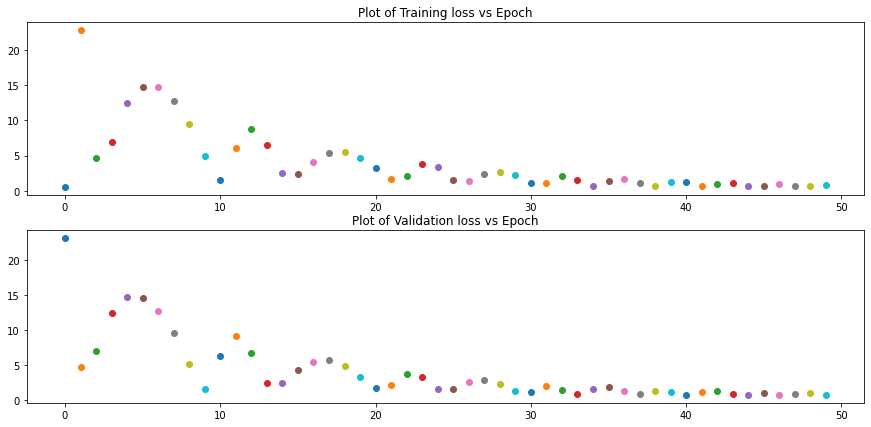

In [ ]:
#Using Adam Optimizer

from torch import optim

train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
valid_labels = torch.tensor(raw_dev['Quality'].map(float), dtype = torch.long)

optimizer = optim.AdamW(paraphrase_model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

#For plot
validation_loss = []
epoch_range = range(50)

fig,ax = plt.subplots(2,1, figsize = (15,7), sharey = 'row')

for epoch in epoch_range:

    paraphrase_model.train()
    logits = paraphrase_model.forward(train)
    train_loss = criterion(logits, train_labels)
       
    ax[0].scatter(epoch, train_loss.item())
    ax[0].set_title("Plot of Training loss vs Epoch")

    print("epoch: {} train accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(logits, train_labels) * 100,train_loss.item()))
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    paraphrase_model.eval() 

    valid_logits = paraphrase_model(dev)
    valid_loss = criterion(valid_logits, valid_labels)
    print("epoch: {} valid accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(valid_logits, valid_labels) * 100,valid_loss.item()))

    ax[1].scatter(epoch, valid_loss.item())
    ax[1].set_title("Plot of Validation loss vs Epoch")

In [ ]:
#Using Adam Optimizer

from torch import optim

train_labels = torch.tensor(raw_train['Quality'].map(float), dtype = torch.long)
valid_labels = torch.tensor(raw_dev['Quality'].map(float), dtype = torch.long)

optimizer = optim.SGD(paraphrase_model.parameters(), lr=0.05)

criterion = nn.CrossEntropyLoss()
paraphrase_model.train()

#For plot
validation_loss = []
epoch_range = range(100)

fig,ax = plt.subplots(2,1, figsize = (15,7), sharey = 'row')

for epoch in epoch_range:   

    logits = paraphrase_model.forward(train)
    train_loss = criterion(logits, train_labels)

    valid_logits = paraphrase_model.forward(dev)
    valid_loss = criterion(valid_logits, valid_labels)
       
    ax[1].scatter(epoch, train_loss.item())
    ax[0].scatter(epoch, valid_loss.item())

    plt.title("Plot of Training loss vs Epoch")
    plt.title("Plot of Validation loss vs Epoch")

    print("epoch: {} train accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(logits, train_labels) * 100,train_loss.item()))
    print("epoch: {} valid accuracy: {:2.2f}, loss: {:5.5f}".format(epoch,accuracy_tensor(valid_logits, valid_labels) * 100,valid_loss.item()))
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


# Extracting other features

In [ ]:

attr = {'is_alpha_1': [], 'is_alpha_2':[], 'is_currency_1': [], 'is_currency_2' : [], 'like_num_1' : [], 
        'like_num_2': [], 'is_punct_1': [], 'is_punct_2': [], 'pos_1': []], 'pos_2': [],
        'is_oov_1' : [], 'is_oov_2' : [], 'is_sent_start_1' : [], 'is_sent_start_2' : []}

def extract_features(dataset: DataFrame, attributes:dict):
  empty = [None for x in range(len(dataset))]
  
  for item in attributes.keys():
    dataset[item] = empty

  for i in range(len(dataset)):
    str1 = nlp(dataset['#1 String'][i])
    str2 = nlp(dataset['#2 String'][i])


    for token_1, token_2 in zip(str1, str2):
      attributes[item].append((token_1.is_alpha)) 
      attributes[item].append((token_1.is_alpha)) 
  return 

In [33]:
empty = [None for x in range(len(raw_train))]


raw_train['is_alpha_1'],raw_train['is_alpha_2'] = empty,empty
raw_train['is_currency_1'], raw_train['is_currency_2'] = empty,empty
raw_train['like_num_1'], raw_train['like_num_2'] = empty,empty

raw_train['is_punct_1'], raw_train['is_punct_2'] = empty,empty
raw_train['pos_1'], raw_train['pos_2'] = empty,empty

raw_train['is_oov_1'], raw_train['is_oov_2'] = empty,empty
raw_train['is_sent_start_1'], raw_train['is_sent_start_2'] = empty,empty

def make_count(alist:list):
  return alist.count(1)

for i in range(len(raw_train)):

  str1 = nlp(raw_train['#1 String'][i])
  str2 = nlp(raw_train['#2 String'][i])
  
  is_alpha_1, is_alpha_2 = [], []
  is_currency_1, is_currency_2 = [], []

  like_num_1, like_num_2 = [], []
  is_punct_1, is_punct_2 = [], []

  pos_1, pos_2 = [], []
  is_oov_1, is_oov_2 = [], []
  is_sent_start_1, is_sent_start_2 = [], []

  raw_train['is_alpha_1'][i] = is_alpha_1

  for token_1, token_2 in zip(str1,str2):
    
    is_alpha_1.append(int(token_1.is_alpha))
    is_alpha_2.append(int(token_2.is_alpha))

    like_num_1.append(int(token_1.like_num))
    like_num_2.append(int(token_2.like_num))
    
    is_currency_1.append(int(token_1.is_currency))
    is_currency_2.append(int(token_2.is_currency))

    like_num_1.append(int(token_1.like_num))
    like_num_2.append(int(token_2.like_num))

    is_currency_1.append(int(token_1.is_currency))
    is_currency_2.append(int(token_2.is_currency))

    is_punct_1.append(int(token_1.is_punct))
    is_punct_2.append(int(token_2.is_punct))

    pos_1.append(token_1.pos_)
    pos_2.append(token_2.pos_)

    is_oov_1.append(int(token_1.is_oov))
    is_oov_2.append(int(token_2.is_oov))

    is_sent_start_1.append(int(token_1.is_sent_start))
    is_sent_start_2.append(int(token_2.is_sent_start))

  raw_train['is_alpha_1'][i] = make_count(is_alpha_1)
  raw_train['is_alpha_2'][i] = make_count(is_alpha_2)

  raw_train['is_currency_1'][i]= make_count(is_currency_1)
  raw_train['is_currency_2'][i] = make_count(is_currency_2)

  raw_train['like_num_1'][i] = make_count(like_num_1)
  raw_train['like_num_2'][i] = make_count(like_num_2)

  raw_train['is_punct_1'][i]= make_count(is_punct_1)
  raw_train['is_punct_2'][i]= make_count(is_punct_2)

  raw_train['pos_1'][i] = pos_1
  raw_train['pos_2'][i] = pos_2

  raw_train['is_oov_1'][i] = make_count(is_oov_1)
  raw_train['is_oov_2'][i] = make_count(is_oov_2)

  raw_train['is_sent_start_1'][i] = make_count(is_sent_start_1)
  raw_train['is_sent_start_2'][i] = make_count(is_sent_start_2)

  #assert type(temp) == int 


In [36]:
raw_train

,Quality,#1 ID,#2 ID,#1 String,#2 String,is_alpha_1,is_alpha_2,is_currency_1,is_currency_2,like_num_1,like_num_2,is_punct_1,is_punct_2,pos_1,pos_2,is_oov_1,is_oov_2,is_sent_start_1,is_sent_start_2,spacy_sim
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",14,16,0,0,0,0,5,3,"[PROPN, VERB, PRON, NOUN, PUNCT, PRON, PRON, V...","[VERB, ADP, PRON, ADP, ADV, PUNCT, DET, NOUN, ...",1,1,1,1,0.949189
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,12,12,2,4,6,6,1,0,"[PROPN, VERB, PROPN, PART, ADP, VERB, DET, NOU...","[PROPN, VERB, PROPN, PART, ADP, NUM, ADP, SYM,...",0,0,1,1,0.935174
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",17,17,0,0,2,2,3,2,"[PRON, AUX, VERB, DET, NOUN, ADP, DET, NOUN, A...","[ADP, PROPN, NUM, PUNCT, DET, NOUN, PART, NOUN...",0,0,1,1,0.950524
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",12,13,2,2,8,6,5,4,"[ADV, NUM, PROPN, PUNCT, NOUN, NOUN, AUX, ADV,...","[NOUN, NOUN, VERB, NUM, NOUN, PUNCT, CCONJ, NU...",0,1,1,1,0.942494
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,16,15,4,4,6,6,3,2,"[DET, NOUN, VERB, SYM, NUM, PUNCT, CCONJ, ADV,...","[PROPN, CCONJ, PROPN, PROPN, NOUN, VERB, SYM, ...",1,1,1,1,0.888213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4071,1,1620264,1620507,""" At this point , Mr. Brando announced : ' Som...","Brando said that "" somebody ought to put a bul...",14,16,0,0,0,0,6,4,"[PUNCT, ADP, DET, NOUN, PUNCT, PROPN, PROPN, V...","[PROPN, VERB, SCONJ, PUNCT, PRON, AUX, PART, V...",0,1,1,1,0.898301
4072,0,1848001,1848224,"Martin , 58 , will be freed today after servin...",Martin served two thirds of a five-year senten...,17,18,0,0,6,4,3,2,"[PROPN, PUNCT, NUM, PUNCT, AUX, AUX, VERB, NOU...","[PROPN, VERB, NUM, NOUN, ADP, DET, NUM, PUNCT,...",0,1,1,1,0.919511
4073,1,747160,747144,""" We have concluded that the outlook for price...","In a statement , the ECB said the outlook for ...",26,27,0,0,0,0,4,3,"[PUNCT, PRON, AUX, VERB, SCONJ, DET, NOUN, ADP...","[ADP, DET, NOUN, PUNCT, DET, PROPN, VERB, DET,...",0,0,1,1,0.923923
4074,1,2539933,2539850,The notification was first reported Friday by ...,MSNBC.com first reported the CIA request on Fr...,8,7,0,0,2,2,1,1,"[DET, NOUN, AUX, ADV, VERB, PROPN, ADP, PROPN,...","[PROPN, ADV, VERB, DET, PROPN, NOUN, ADP, PROP...",0,0,1,1,0.722712


In [ ]:

from collections import defaultdict

attribute = defaultdict()

In [ ]:
is_digit = []
for j,entry in enumerate(raw_train['#1 String'].map(nlp)):
  temp = []
  for i, token in enumerate(entry):
    if token.is_digit == False:
      pass
    else:
      temp.append(token.is_digit)

  raw_train['1rs_is_digit'][j] = len(temp)
  #is_digit.append(temp)


In [ ]:
is_digit = []
for j,entry in enumerate(raw_train['#2 String'].map(nlp)):
  temp = []
  for i, token in enumerate(entry):
    if token.is_digit == False:
      pass
    else:
      temp.append(token.is_digit)
      
  raw_train['2rs_is_digit'][j] = len(temp)

KeyError: ignored

In [ ]:
#Extract features from pos